../../dataset/v0/ONJ/EW-0197
../../dataset/v0/ONJ/EW-0437
../../dataset/v0/ONJ/EW-0321
../../dataset/v0/ONJ/EW-0449
../../dataset/v0/ONJ/EW-0172
../../dataset/v0/ONJ/EW-0454
../../dataset/v0/ONJ/EW-0267
../../dataset/v0/ONJ/EW-0096
../../dataset/v0/ONJ/EW-0450
../../dataset/v0/ONJ/EW-0489


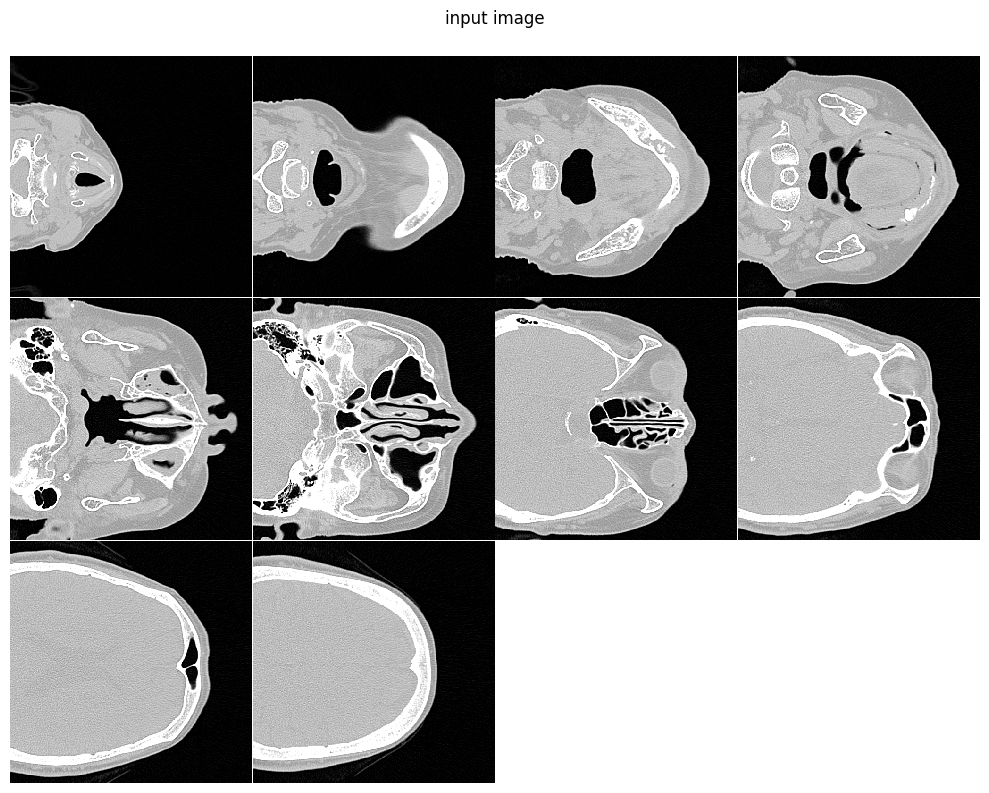

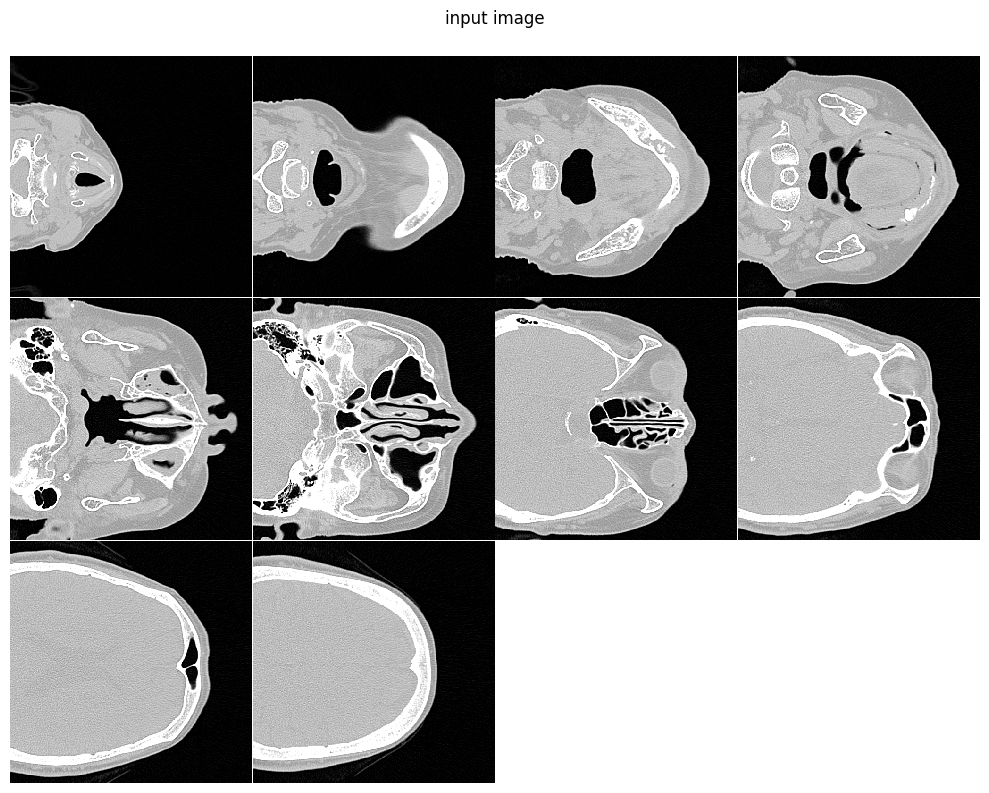

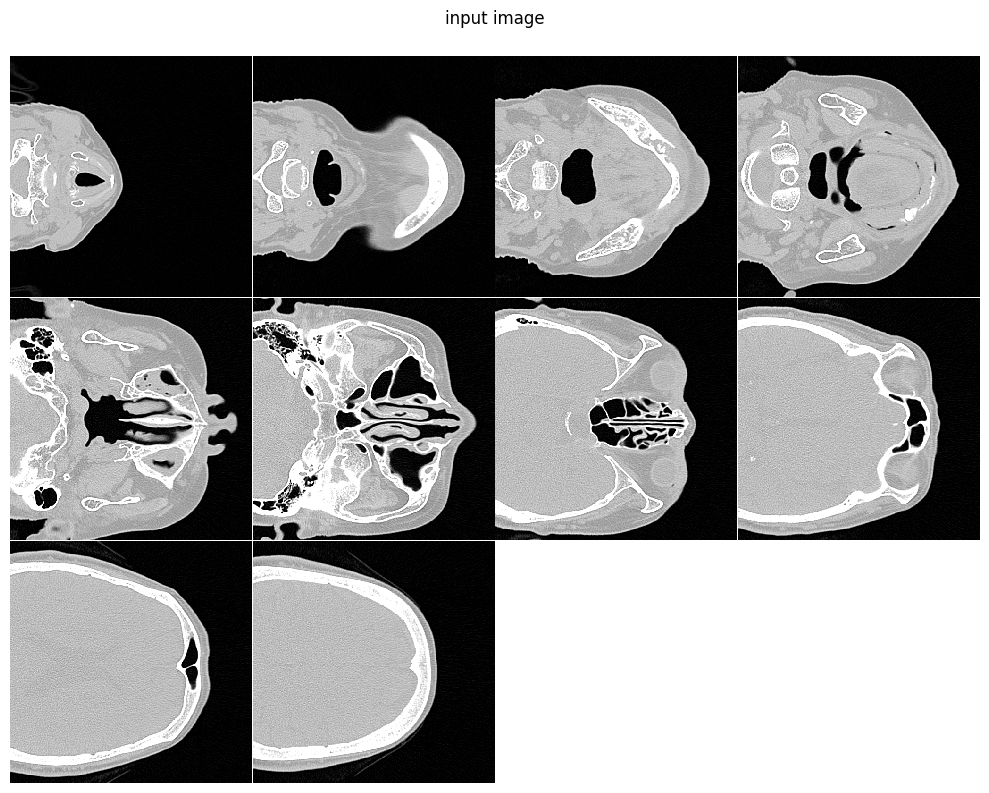

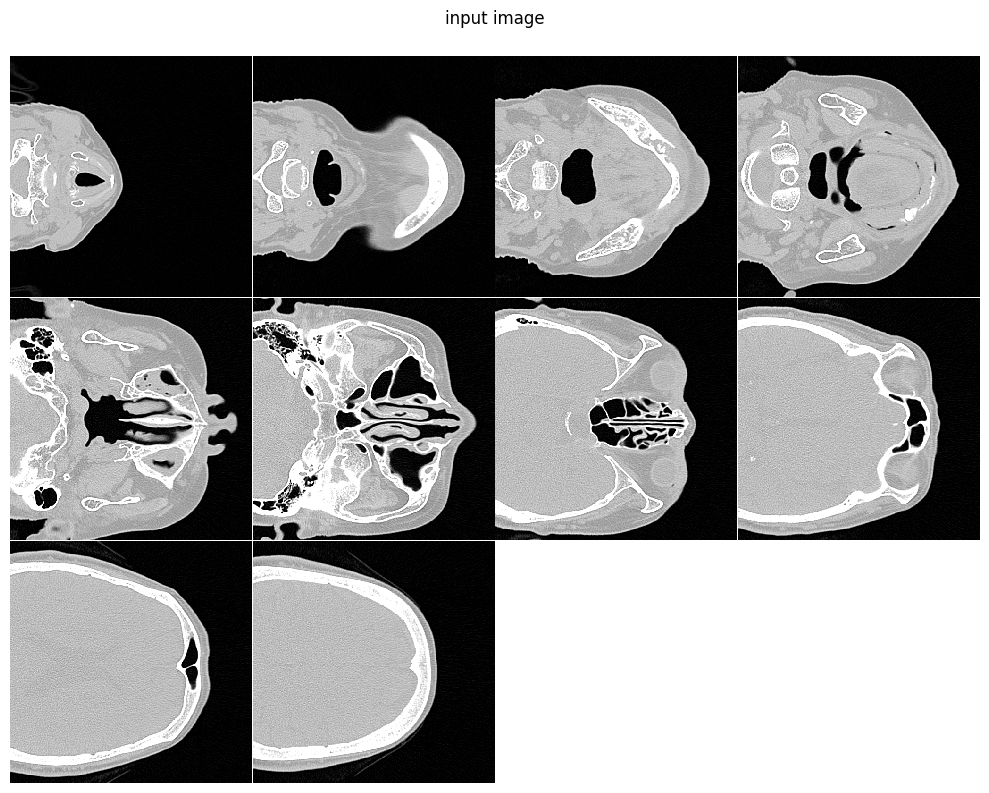

KeyboardInterrupt: 

In [5]:
import monai
import torch
import numpy as np
import os

from pathlib import Path

import json

from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    MapTransform,
    Transform,
    LoadImaged,
    ScaleIntensityRanged,
    ToTensord,
    EnsureChannelFirstd,
    Resized,
)
from monai.config.type_definitions import NdarrayTensor

from monai.visualize.utils import blend_images, matshow3d  ## label과 Image를 합친 영상  ## 3d image의 visulization

from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # load a pretrained YOLOv8n detection model


DIM = 512


class LoadJsonLabel(MapTransform):
    """
    Custom transform to load bounding box coordinates from a JSON file.
    """

    def __init__(self, keys: str, allow_missing_keys: bool = False):
        MapTransform.__init__(self, keys, allow_missing_keys)

    def __call__(self, data: dict) -> dict:
        total_slices = data["image"].shape[-1]

        data_path = data["label"]
        if data_path == "":
            t = torch.zeros((total_slices, 5))
            data["label"] = t
            return data

        with open(data_path, "r") as file:
            labels = json.load(file)

        num_labels = len(labels["slices"])
        label_start = labels["slices"][0]["slice_number"]
        label_end = labels["slices"][-1]["slice_number"]

        t = torch.zeros((total_slices, 5), dtype=torch.int32)

        for i in range(num_labels):
            slice = labels["slices"][i]
            slice_number = slice["slice_number"]
            # TODO: Check if the coordinate type is x, y, w, h
            x = int(slice["bbox"][0]["coordinates"][0] * DIM)
            y = int(slice["bbox"][0]["coordinates"][1] * DIM)
            w = int(slice["bbox"][0]["coordinates"][2] * DIM)
            h = int(slice["bbox"][0]["coordinates"][3] * DIM)

            t[slice_number] = torch.tensor([1, x, y, w, h])

        data["label"] = t

        return data


transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        LoadJsonLabel(keys=["label"]),  # Use the custom transform for labels
        ScaleIntensityRanged(keys=["image"], a_min=-1000, a_max=400, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=["image"], spatial_size=(DIM, DIM, -1), mode="trilinear"),
        ToTensord(keys=["image"]),
    ]
)


# create data_dicts
DATA_PATH = Path("../../dataset/v0/ONJ")

data_dicts = []

i = 0
j = 0
for patient in DATA_PATH.glob("*"):
    if (patient / "label.json").exists():
        # print(patient / "label.json")
        i += 1
        if (patient / "CBCT").exists():
            for modal_dir in (patient / "CBCT").glob("*/*"):
                if "nifti" in os.listdir(modal_dir) and "label.json" in os.listdir(modal_dir):
                    data_dicts.append(
                        {
                            "image": modal_dir / "nifti" / "output.nii.gz",
                            "label": modal_dir / "label.json",
                        }
                    )

        if (patient / "MDCT").exists():
            for modal_dir in (patient / "MDCT").glob("*/*"):
                if not modal_dir.is_dir():
                    continue
                if "nifti" in os.listdir(modal_dir) and "label.json" in os.listdir(modal_dir):
                    data_dicts.append(
                        {
                            "image": modal_dir / "nifti" / "output.nii.gz",
                            "label": modal_dir / "label.json",
                        }
                    )
    else:
        print(patient)

    j += 1

# Create a MONAI dataset
dataset = Dataset(data=data_dicts, transform=transforms)

# Use DataLoader to load the dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

import cv2

# Iterate over the dataloader
for batch in dataloader:
    # print(batch["image"].shape, batch["label"])
    sample_image = dataset[0]["image"][..., 145]
    sample_label = dataset[0]["label"][145, :]
    (x, y, w, h) = np.array(sample_label[1:])
    im = np.array(sample_image)
    # cv2.rectangle(im[0], (x, y), (x + w, y + h), (255,), 2)
    cv2.imwrite("sa.png", im[0])
    pass

    plt = matshow3d(
        volume=dataset[0]["image"][..., 1::20],
        fig=None,
        title="input image",
        frame_dim=-1,
        show=True,
        cmap="gray",
    )
